# Initialisation

In [10]:
from google.colab import drive, files
import os
import sys
PROJDIR = '/content/drive/My Drive/Colab Notebooks/P7_Réalisez des indexations automatiques d’images'

drive.mount('/content/drive') 
os.chdir(PROJDIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import tarfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import pickle
import random
from PIL import Image, ImageOps
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn import cluster, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import cv2
import timeit

from skimage.transform import resize
%matplotlib inline
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, VGG16, decode_predictions
from keras.models import Model

# Constantes et fonctions

In [ ]:
WIDTH = 224
HEIGHT = 224
STEP = 1000
SAMPLE = 50

#Generator
def generator(df):
    while 1:
        for i in range(len(df)):
            x = cv2.imread(df.iloc[i].path)
            x = cv2.resize(x, (WIDTH, HEIGHT))
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            y = df.iloc[i]['breed_lbl'].reshape(-1, 1)
            y = onehot.transform(y).toarray()
            yield (x, y)

def nettoyage(path):
    """
    Fonction de nettoyage des images 
    """
    img = Image.open(path)

    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Dimensionnement des images 
    img_conv = img.resize((WIDTH, HEIGHT))
    #img_conv = cv2.resize(img, (WIDTH, HEIGHT))

    #img_conv = cv2.cvtColor(img_conv, cv2.COLOR_BGR2GRAY)

    # Correction de l'exposition
    img_conv = ImageOps.autocontrast(img_conv)

    # Correction du contraste
    img_conv = ImageOps.equalize(img_conv)
    #img = cv2.equalizeHist(img)

    # Application d'un filtre médian
    img_conv = cv2.medianBlur(np.array(img_conv), 5)

    # Passage en noir et blanc
    img_conv = cv2.cvtColor(img_conv, cv2.COLOR_BGR2GRAY)

    return img_conv.flatten()

# Dézippage des photos

In [ ]:
os.chdir('/content/drive/My Drive/')
!rm *.jpg

os.chdir(PROJDIR)
!rm -r Images

rm: cannot remove '*.jpg': No such file or directory


In [ ]:
breeds = [] 
path_img = [] 
tailles = [] 
modes = [] 
temp = []
temp_gray = []
step = 0
nbreeds = 0

start_time = timeit.default_timer()

with tarfile.open('images.tar', 'r:tar') as tarFile:
    #tarInfo = tarFile.next()
    for fpath in tarFile.getmembers():
        if fpath.isfile():
            tarFile.extract(fpath)

            last_slash = fpath.name.rfind('/')
            breed = fpath.name[fpath.name.rfind('/', 1, last_slash)+1:last_slash]
            breed = breed[breed.find('-')+1:]

            tarFile.extract(fpath)

            path_img.append('./' + fpath.name)
            breeds.append(breed)

            step  = len(path_img) 
            if step % STEP == 0:
                print("{} {:.2f}s".format(step, timeit.default_timer()-start_time))
                #break
                
if step % STEP != 0:
    print("{} {:.2f}s\n".format(step, timeit.default_timer()-start_time))

dogs_paths = pd.DataFrame({'path':path_img, 'breed':breeds})

print("Fin {} {:.2f}s".format(dogs_paths.shape, timeit.default_timer()-start_time))

1000 45.21s
2000 70.99s
3000 95.16s
4000 119.33s
5000 143.72s
6000 168.08s
7000 192.86s
8000 217.46s
9000 242.23s
10000 266.47s
11000 290.65s
12000 314.73s
13000 338.83s
14000 363.37s
15000 388.02s
16000 412.24s
17000 436.64s
18000 460.89s
19000 485.28s
20000 511.22s
20580 525.40s

Fin (20580, 2) 525.41s


In [12]:
with open('OC_DS_P7_dogs_paths.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL)
    pickler.dump(dogs_paths)

In [13]:
dogs_paths.head()

,path,breed
0,./Images/n02085620-Chihuahua/n02085620_10621.jpg,Chihuahua
1,./Images/n02085620-Chihuahua/n02085620_10976.jpg,Chihuahua
2,./Images/n02085620-Chihuahua/n02085620_11238.jpg,Chihuahua
3,./Images/n02085620-Chihuahua/n02085620_11258.jpg,Chihuahua
4,./Images/n02085620-Chihuahua/n02085620_11337.jpg,Chihuahua


# Exploration

## Galerie

KeyboardInterrupt: ignored

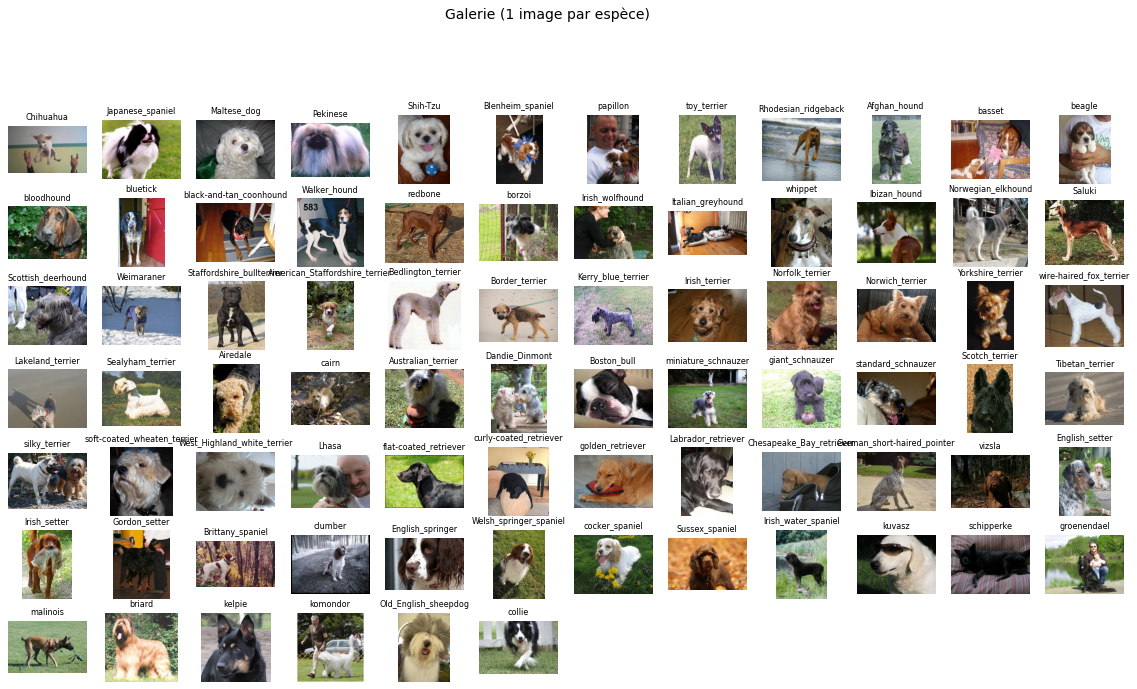

In [17]:
temp = []
tailles = []
modes = []
nbreeds = 0

fig = plt.figure(figsize=(20, 15))
plt.suptitle('Galerie (1 image par espèce)', fontsize=14)

for i, v in dogs_paths.iterrows():
    breed = v['breed']
    
    img = Image.open(v['path'])
    tailles.append(img.size)
    modes.append(img.mode)

    if breed not in temp:
        nbreeds += 1
        plt.subplot(10, 12, nbreeds)
        plt.title(breed, fontsize=8)
        plt.axis('off')
        plt.imshow(img)
        temp.append(breed)

## Modes et tailles initiales des photos

Modes
RGB     20579
RGBA        1
dtype: int64



Text(0, 0.5, 'height')

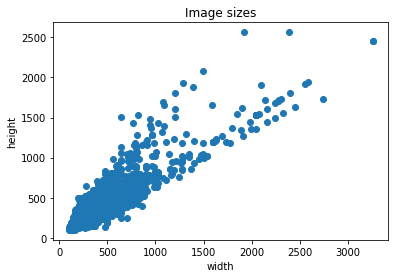

In [ ]:
print('Modes\n{}\n'.format(pd.Series(modes).value_counts()))

shapes = np.asarray(tailles)
plt.plot(shapes[:, 0], shapes[:, 1], "o")
plt.title("Image sizes")
plt.xlabel("width")
plt.ylabel("height")

## Distribution et étiquetage des espèces

In [ ]:
breeds = dogs_paths['breeds']

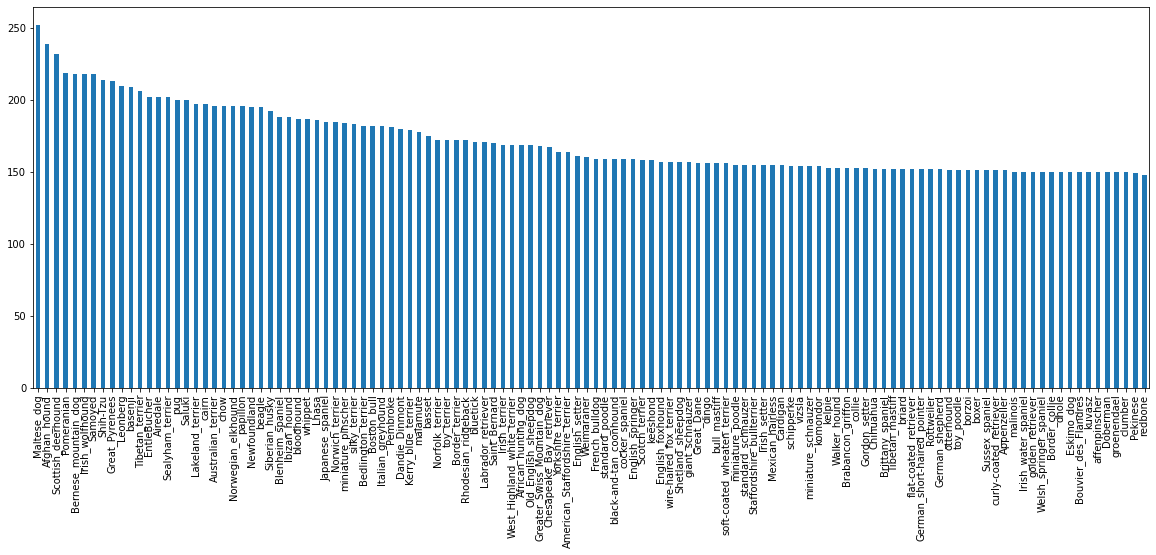

In [ ]:
fig = plt.figure(figsize=(20, 7))
dogs_paths.breed.value_counts().plot.bar()

breed_lbl = LabelEncoder() 
dogs_paths['breed_lbl'] = breed_lbl.fit_transform(breeds)

## Réduction du nombre d'images (SAMPLE) par espèce
Les défaut de performance matérielle empêche le traitement de l'exhaustivité

(6000, 3)


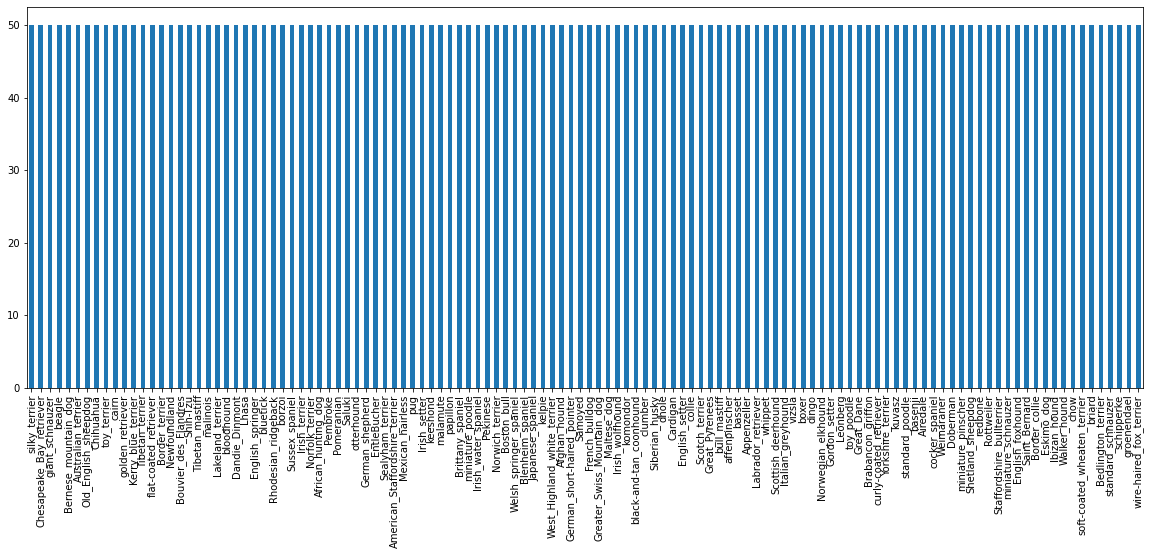

In [ ]:
idx_sample = [] 

for breed in set(breeds):
    idx_sample.extend(dogs_paths[dogs_paths.breed == breed].sample(SAMPLE).index.tolist())

dogs_sample = dogs_paths[dogs_paths.index.isin(idx_sample)]
print(dogs_sample.shape)

fig = plt.figure(figsize=(20, 7))
dogs_sample.breed.value_counts().plot.bar()

In [ ]:
nb_clusters = len(dogs_sample.breed.unique())
nb_clusters

120

# Approches standards

## Nettoyage des images et passage en noir et blanc

In [ ]:
start_time = timeit.default_timer()

dogs_sample = dogs_sample.assign(img = dogs_sample['path'].apply(nettoyage))

print("Fin {} {:.2f}s".format(dogs_sample.shape, timeit.default_timer()-start_time))
dogs_sample.head()

Fin (6000, 4) 51.51s


,path,breed,breed_lbl,img
0,./Images/n02085620-Chihuahua/n02085620_10621.jpg,Chihuahua,17,"[39, 39, 39, 41, 43, 44, 45, 47, 47, 52, 52, 5..."
2,./Images/n02085620-Chihuahua/n02085620_11238.jpg,Chihuahua,17,"[242, 242, 242, 241, 240, 240, 241, 241, 240, ..."
9,./Images/n02085620-Chihuahua/n02085620_1205.jpg,Chihuahua,17,"[6, 6, 2, 2, 2, 2, 6, 6, 6, 6, 16, 16, 21, 21,..."
10,./Images/n02085620-Chihuahua/n02085620_12334.jpg,Chihuahua,17,"[192, 187, 172, 170, 162, 153, 126, 109, 99, 9..."
14,./Images/n02085620-Chihuahua/n02085620_1321.jpg,Chihuahua,17,"[234, 235, 235, 235, 233, 230, 228, 225, 224, ..."


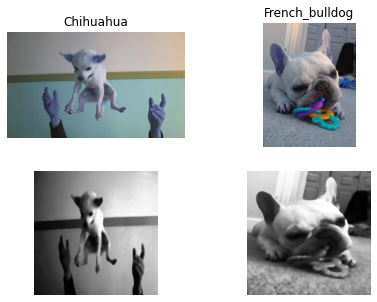

In [ ]:
fig = plt.figure(figsize=(7, 5))
plt.subplot(221)
plt.title(dogs_sample.breed.iloc[0])
plt.imshow(cv2.imread(dogs_sample.path.iloc[0]))
plt.axis('off')
plt.subplot(223)
plt.imshow(dogs_sample.img.iloc[0].reshape(WIDTH, HEIGHT), cmap='gray')
plt.axis('off')
#plt.show()
plt.subplot(222)
plt.title(dogs_sample.breed.iloc[-1])
plt.imshow(cv2.imread(dogs_sample.path.iloc[-1]))
plt.axis('off')
plt.subplot(224)
plt.imshow(dogs_sample.img.iloc[-1].reshape(WIDTH, HEIGHT), cmap='gray')
plt.axis('off')
plt.show()

### Réduction de dimension (PCA)

In [ ]:
dogs_sample.img.values

array([array([ 39,  39,  39, ..., 168, 168, 168], dtype=uint8),
       array([45, 44, 39, ..., 85, 85, 85], dtype=uint8),
       array([242, 242, 242, ..., 151, 151, 150], dtype=uint8), ...,
       array([65, 71, 78, ..., 34, 70, 89], dtype=uint8),
       array([212, 211, 207, ..., 225, 228, 232], dtype=uint8),
       array([ 49,  48,  43, ..., 162, 160, 158], dtype=uint8)],
      dtype=object)

In [ ]:
X = np.array(dogs_sample.img.values
X.shape, X.min(), X.max()

ValueError: ignored

In [ ]:
"""
X_sub, y_sub = zip(*random.sample(list(zip(dogs_img, breeds)), 5000))
X_sub = np.array(X_sub)
y_sub = np.array(y_sub)
X_sub.shape
"""

(5000, 150528)

In [ ]:
"""
X = dogs_img 

scaler = MinMaxScaler(feature_range=(0,1))
X_scaled = scaler.fit_transform(X)
"""

In [ ]:
argmax = []
cpt = 0 
VARIANCE = .95
STEP = 1000

X_scaled = X / 255

start_time = timeit.default_timer()

pca = PCA(VARIANCE)

pca.fit(X_scaled)

min_features = pca.n_components_
print('PCA min features {} en {:.2f}s'.format(min_features, timeit.default_timer()-start_time))

PCA min features 621 en 452.07s


Je fixe le nombre de composants à 1000


In [ ]:
start_time = timeit.default_timer()

pca = PCA(n_components=2000)
X_scaled_pca = pca.fit_transform(X_scaled)

print('Durée {:.2f}s'.format(timeit.default_timer()-start_time))

X_scaled_pca.shape

Durée 247.24s


(6000, 2000)

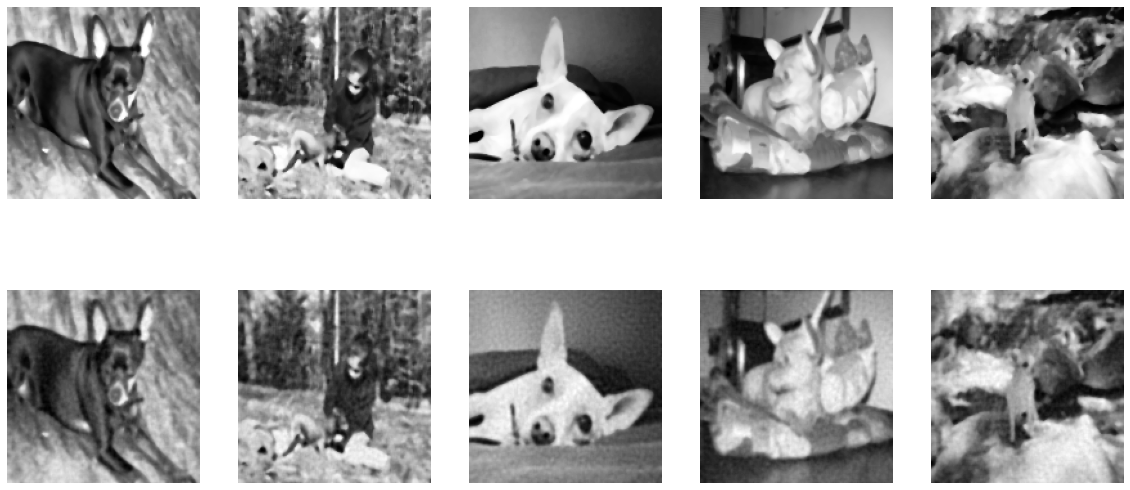

In [ ]:
num = 5 
cpt = 0

plt.figure(figsize=(20,20))

for cpt in range(num):

    plt.subplot(4, 5, 1 + cpt + num * (cpt // num))
    plt.axis('off')
    plt.imshow(X_scaled[cpt].reshape(150, 150), cmap='gray')

    plt.subplot(4, 5, 6 + cpt + num * (cpt // num))
    plt.axis('off')
    plt.imshow((pca.inverse_transform(X_scaled_pca[cpt])).reshape(150, 150), cmap='gray')

## Classifieur Forêts Aléatoires

In [ ]:
start_time = timeit.default_timer()

# split train and test data
x_train, x_test, y_train, y_test = train_test_split(X_scaled_pca, y, test_size=0.3, random_state=0)

#train model with randomforestclassifer
clf_rfc = RandomForestClassifier().fit(x_train, y_train)

# evaluate the model with test data
y_pred_rfc = clf_rfc.predict(x_test)
print(metrics.precision_score(y_test, y_pred_rfc, average='weighted'))
print(metrics.accuracy_score(y_test, y_pred_rfc))
print('Durée {:.2f}s'.format(timeit.default_timer()-start_time))

0.019729973260859297
0.01611111111111111
Durée 451.30s


## kMeans des features

### Feature detection

In [ ]:
NEW_SHAPE = 150 
features = []
l = []
w = []
cpt = 0 

orb = cv2.ORB_create(nfeatures=100)  # OpenCV 3 backward incompatibility: Do not create a detector with `cv2.ORB()`.

start_time = timeit.default_timer()

for i in dogs_sample.img.values:
    
    img = cv2.resize(i.reshape(WIDTH, HEIGHT), (NEW_SHAPE, NEW_SHAPE))
    key_points, descriptor = orb.detectAndCompute(img, None)
    #keypoints = orb.detect(img, None)
    #keypoints, descriptors = orb.compute(img, keypoints)

    l.append(descriptor.shape[0])
    w.append(descriptor.shape[1])

    #descriptor = descriptor.reshape(-1, 1)
    features.append(descriptor)
    
    cpt += 1
    if cpt % STEP == 0:
        print("{} {:.2f}s".format(cpt, timeit.default_timer()-start_time))

if cpt % STEP != 0:
    print("{} {:.2f}s".format(cpt, timeit.default_timer()-start_time))

1000 1.55s
2000 3.06s
3000 4.57s
4000 6.11s
5000 7.66s
6000 9.19s


In [ ]:
X_features = np.vstack(np.array(features, dtype='object')) / 255
print(X_features.shape)

(415270, 32)


In [ ]:
X_features.min(), X_features.max()

(0.0, 1.0)

### Clustering

In [ ]:
start_time = timeit.default_timer()

fig = plt.figure(figsize=(10, 5))
# Iteration de clustering kmeans avec des nb de clusters différents
silhouettes = []
inertia = []
cluster_range = range(5, 206, 20)
init_range = range(8, 19)

for i in init_range:
    myclust = cluster.KMeans(n_clusters=nb_clusters, random_state=1, init="k-means++", n_init=i).fit(X_features)
    #print('n_cluster {} {:.2f}s'.format(n, timeit.default_timer()-start_time))
    print('n_init {} {:.2f}s'.format(i, timeit.default_timer()-start_time))
    #silhouettes.append(metrics.silhouette_score(X_scaled_pca, myclust.labels_))
    inertia.append(np.sqrt(myclust.inertia_))

plt.plot(init_range, inertia, marker='o')

#best_cluster = cluster_range[np.argmax(silhouettes)]
#print('best clustering = ', best_cluster)

KeyboardInterrupt: ignored

<Figure size 720x360 with 0 Axes>

In [ ]:
start_time = timeit.default_timer()

# Using KMeans to compute centroids to build bag of visual words,n_clusters = 6, 
kmeans = cluster.KMeans(n_clusters=nb_clusters, random_state=0).fit(X_features)
print('Fin {:.2f}s'.format(timeit.default_timer()-start_time))

Fin 1137.37s


In [ ]:
start_time = timeit.default_timer()
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_features, kmeans.labels_))
print('Fin {:.2f}s'.format(timeit.default_timer()-start_time))

Silhouette Coefficient: 0.031
Fin 2723.52s


In [ ]:
# creating bag of visual words feature vectors for the images in the list
bovw_v = np.zeros([len(features), nb_clusters])
for index, feature in enumerate(features):
  for i in kmeans.predict(feature):
    bovw_v[index, i] +=1
    continue
  continue
  break

In [ ]:
y = dogs_sample.breed_lbl

In [ ]:
# starting training and prediction using bovw feature vectors & labels
x_train, x_test, y_train, y_test = train_test_split(bovw_v, y, test_size=0.2, random_state=0)

clf_svc = SVC().fit(x_train, y_train)

# evaluating model
y_pred_svc = clf_svc.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred_svc))
print(metrics.precision_score(y_test, y_pred_svc, average='weighted', labels=np.unique(y_pred_svc)))

0.004166666666666667
0.013938294010889292


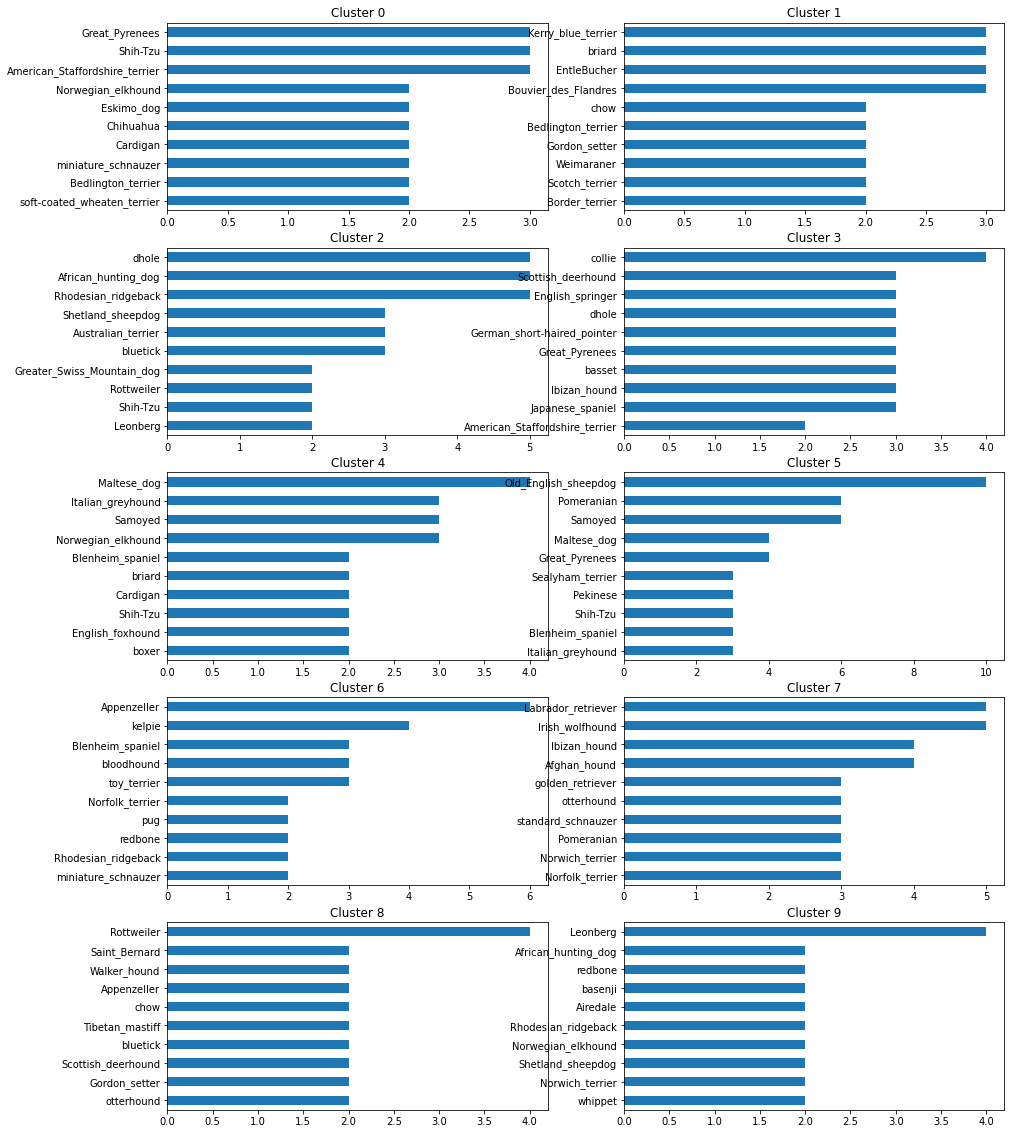

In [ ]:
fig = plt.figure(figsize=(15, 20))

for c in range(10):
    plt.subplot(5, 2, c+1)
    plt.title('Cluster {}'.format(c))
    dogs_sample[dogs_sample.cluster == c].breed.value_counts(ascending=True)[-10:].plot.barh()

NameError: ignored

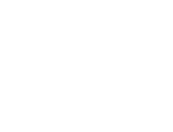

In [ ]:
#Visualisation for clusters = clust
plt.figure(figsize=(20,10))
clust = 2 #enter label number to visualise
num = 20 #num of data to visualize from the cluster
for i in range(1,num): 
    plt.subplot(4, 6, i) #(Number of rows, Number of column per row, item number)
    plt.axis('off')
    plt.imshow(X_scaled[cluster_index[clust][i]].reshape(150, 150) * 255, cmap='gray')
    
#plt.show()

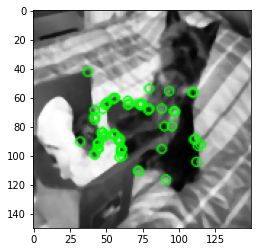

In [ ]:
kp_img = cv2.drawKeypoints(gray_samples.img.iloc[-1], key_points, None, color=(0, 255, 0), flags=cv2.DrawMatchesFlags_DEFAULT)
plt.imshow(kp_img)

In [ ]:
with open('OC_DS_P7_X_scaled_pca.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL)
    pickler.dump(X_scaled_pca)

# CNN

## Séparation train/test

In [ ]:
base_model = VGG16()

553467904/553467096 [==============================] - 5s 0us/step


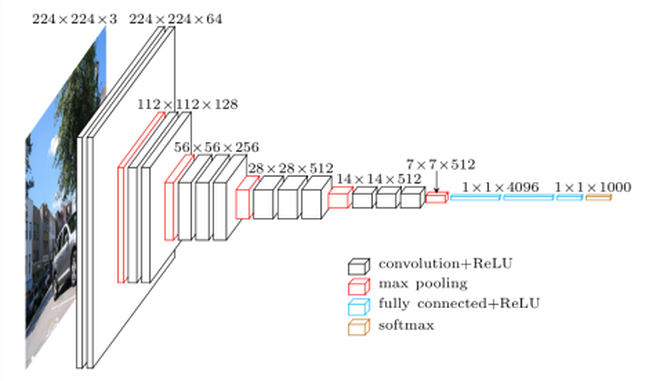

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Base line

In [ ]:
temp = dogs_sample.sample(6)
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 6542 to 7494
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   path       6 non-null      object
 1   breed      6 non-null      object
 2   breed_lbl  6 non-null      int64 
dtypes: int64(1), object(2)
memory usage: 192.0+ bytes


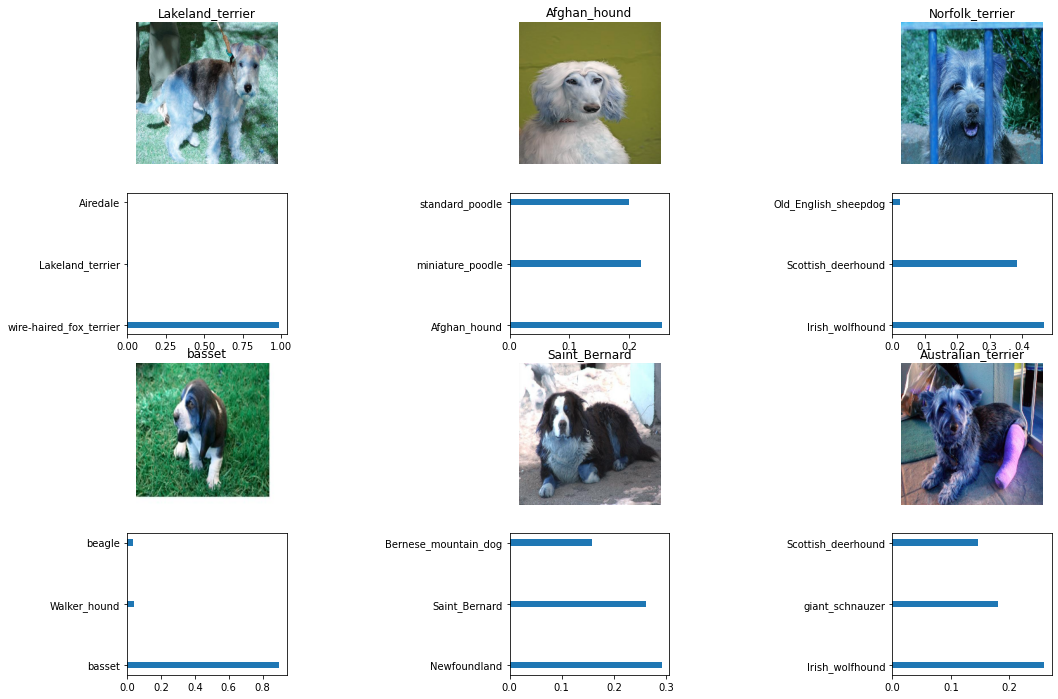

In [ ]:
fig = plt.figure(figsize=(20, 12))
cpt = 0 

for i, v in temp.iterrows(): 
    cpt += 2 

    img = cv2.imread(v.path)
    img = cv2.resize(img, (WIDTH, HEIGHT))
    img_vgg = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
    img_vgg = preprocess_input(img_vgg)  # Prétraiter l'image comme le veut VGG-16

    y = base_model.predict(img_vgg)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)
    pred = decode_predictions(y, top=3)[0]

    plt.subplot(4, 6, cpt + 6 * np.floor(cpt/7))
    plt.axis('off')
    plt.title(v.breed)
    plt.imshow(img)

    plt.subplot(4, 6, cpt + 6 * (1 + np.floor(cpt/7)))
    plt.barh([w[1] for w in pred], [w[2] for w in pred], height=.1)
    # Afficher les 3 classes les plus probables
    #print('Top 3 :', decode_predictions(y, top=3)[0])

## Transfer learning

J'entraine seulement les couches les plus hautes (fine-tunning partiel)

In [ ]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [ ]:
onehot = OneHotEncoder()
y = onehot.fit_transform(np.expand_dims(dogs_sample.breed_lbl, axis=1)).toarray()

gen = generator(dogs_sample)

## Prédictions finales

In [ ]:
X_pred = model.predict(gen, steps=len(dogs_sample), verbose=1)

12000/12000 [==============================] - 184s 15ms/step


In [ ]:
y = dogs_sample.breed_lbl

X_train, X_test, y_train, y_test = train_test_split(X_pred, y)

In [ ]:
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = clf.predict(X_test)

## Evaluation

In [ ]:
acc = metrics.accuracy_score(y_test, y_pred)

print("Accuracy : {:.2f}%".format(acc*100))

Accuracy : 39.57%
